
# Proyecto de Deep Learning: Clasificación de Estados Oculares Usando Señales EEG con LSTM
**Diplomado en Ciencia de Datos**

**Nombre:** Andrea Fernanda García Guzmán  


---

## Introducción

El estudio de señales EEG (electroencefalografía) es una herramienta clave en neurociencia y medicina. Estas señales reflejan la actividad eléctrica cerebral y permiten analizar distintos estados fisiológicos, como la concentración, el sueño o el estado ocular (abierto o cerrado). Dado su carácter secuencial y dependiente del tiempo, las redes neuronales recurrentes (RNN), particularmente las unidades LSTM (Long Short-Term Memory), resultan una opción ideal para modelar estos datos.

Este proyecto utiliza el dataset **EEG Eye State** del Repositorio de Aprendizaje Automático de la UCI, con el objetivo de clasificar el estado ocular a partir de 14 señales EEG por muestra. Se implementa un modelo LSTM y se discuten los resultados obtenidos.

---

## Justificación del uso de LSTM

Las LSTM permiten retener información a largo plazo a través de puertas de memoria, superando el problema del *desvanecimiento del gradiente* presente en las RNN tradicionales. Esto es crucial en señales EEG, donde el contexto de estados previos puede aportar información valiosa para la clasificación actual.

---

## Descripción del Dataset

- **Fuente:** [UCI EEG Eye State Dataset](https://archive.ics.uci.edu/ml/datasets/eeg+eye+state)
- **Observaciones:** 14,980
- **Atributos:** 14 canales EEG + 1 etiqueta binaria (estado ocular)
- **Etiquetas:** `0` = Ojos abiertos, `1` = Ojos cerrados
    

## 1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


## 2. Lectura


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Diplomado /Módulo VI/eeg-eye-state.csv"
data = pd.read_csv(file_path)

print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación general:")
print(data.info())
print("\nDistribución de clases (0: ojos abiertos, 1: ojos cerrados):")
# Access the last column using iloc
print(data.iloc[:, -1].value_counts())



Primeras filas del dataset:
       AF3       F7       F3      FC5       T7        P       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4  class  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85      0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10      0  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23      0  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41      0  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46      0  

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 

## 3. Análisis exploratorio

<ipython-input-5-e6156945e019>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='eye_state', data=data, palette='coolwarm')


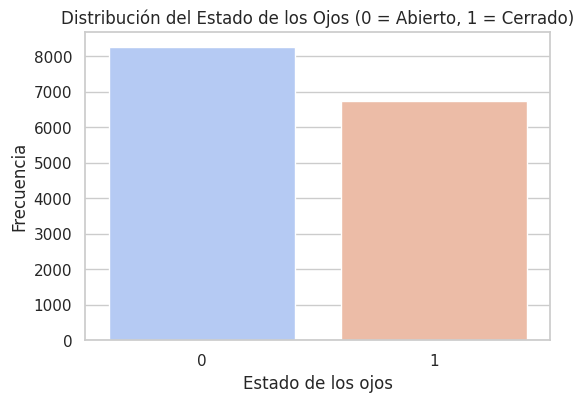

In [ ]:
columns = [f"EEG_{i}" for i in range(14)] + ["eye_state"]
data.columns = columns

# Revisamos distribución de la variable objetivo
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x='eye_state', data=data, palette='coolwarm')
plt.title('Distribución del Estado de los Ojos (0 = Abierto, 1 = Cerrado)')
plt.xlabel('Estado de los ojos')
plt.ylabel('Frecuencia')
plt.show()


### Señales EEG en el tiempo

Para tener una idea visual de cómo se comportan las señales EEG, graficamos algunas de ellas en un pequeño segmento de tiempo.


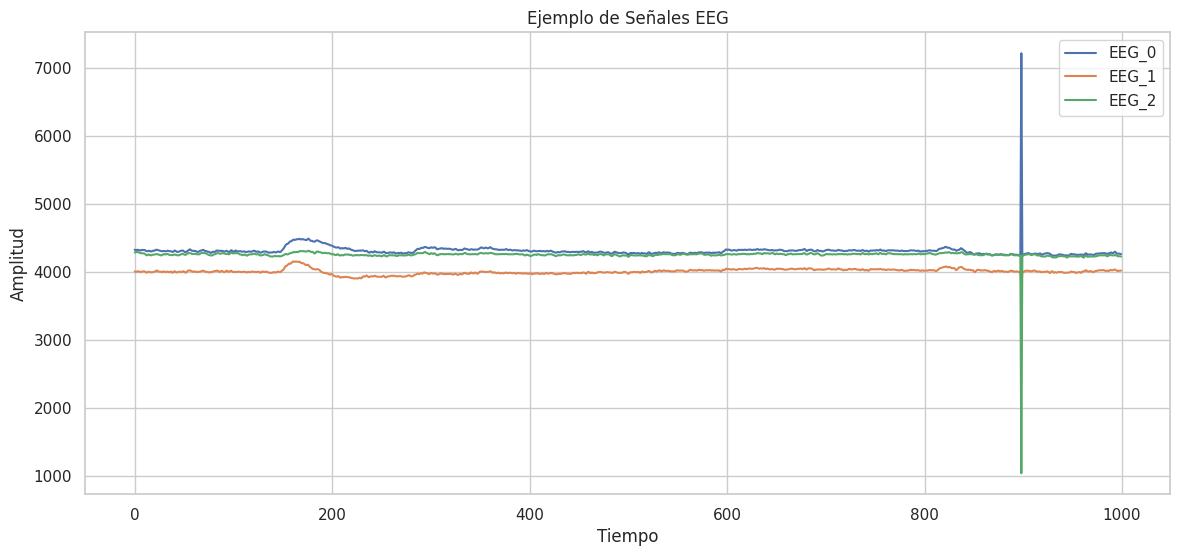

In [ ]:
# Graficamos 3 señales EEG
n_samples = 1000  # primeros mil registros
plt.figure(figsize=(14,6))
for i in range(3):
    plt.plot(data.iloc[:n_samples, i], label=f'EEG_{i}')
plt.title('Ejemplo de Señales EEG')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.show()


### Mapa de calor de correlaciones

El siguiente mapa de calor nos permite observar si algunas señales EEG están correlacionadas entre sí, lo cual podría influir en el diseño del modelo.


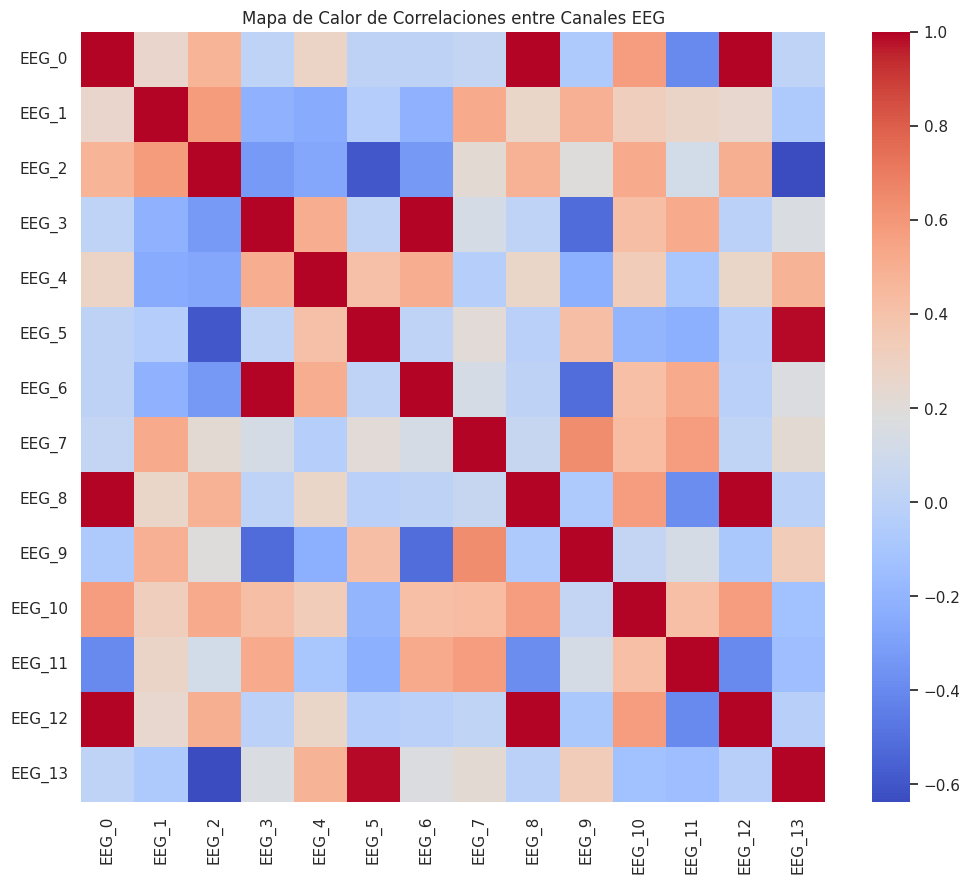

In [ ]:
# Mapa de correlaciones
plt.figure(figsize=(12,10))
sns.heatmap(data.iloc[:, :-1].corr(), cmap='coolwarm', annot=False)
plt.title('Mapa de Calor de Correlaciones entre Canales EEG')
plt.show()


### Observaciones del EDA

- El dataset está relativamente balanceado entre las clases `0` y `1`, aunque hay una ligera mayoría de ojos cerrados.
- Algunas señales EEG muestran correlaciones moderadas, lo que sugiere redundancia de información.
- Las señales muestran variaciones temporales típicas de registros EEG, lo que hace apropiado el uso de redes neuronales recurrentes (RNN) como LSTM.


## Limpieza y procesamiento de datos


In [ ]:
# Normalizamos las señales EEG
scaler = MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, :-1])
y = data['eye_state'].values

# Convertimos a secuencias para alimentar a LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)


## 4. Construcción del modelo RNN (LSTM)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, X.shape[1]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento del modelo

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5447 - loss: 0.6891 - val_accuracy: 0.5455 - val_loss: 0.6891
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5546 - loss: 0.6878 - val_accuracy: 0.5455 - val_loss: 0.6891
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5453 - loss: 0.6900 - val_accuracy: 0.5455 - val_loss: 0.6900
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5515 - loss: 0.6887 - val_accuracy: 0.5455 - val_loss: 0.6892
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5555 - loss: 0.6870 - val_accuracy: 0.5455 - val_loss: 0.6890
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5596 - loss: 0.6866 - val_accuracy: 0.5455 - val_loss: 0.6893
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5434 - loss: 0.6894 - val_accuracy: 0.5455 - val_loss: 0.6893
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5587 - loss: 0.6864 - val_accu

## 6. Evaluación del modelo

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5914 - loss: 0.6747

Precisión en conjunto de prueba: 58.15%


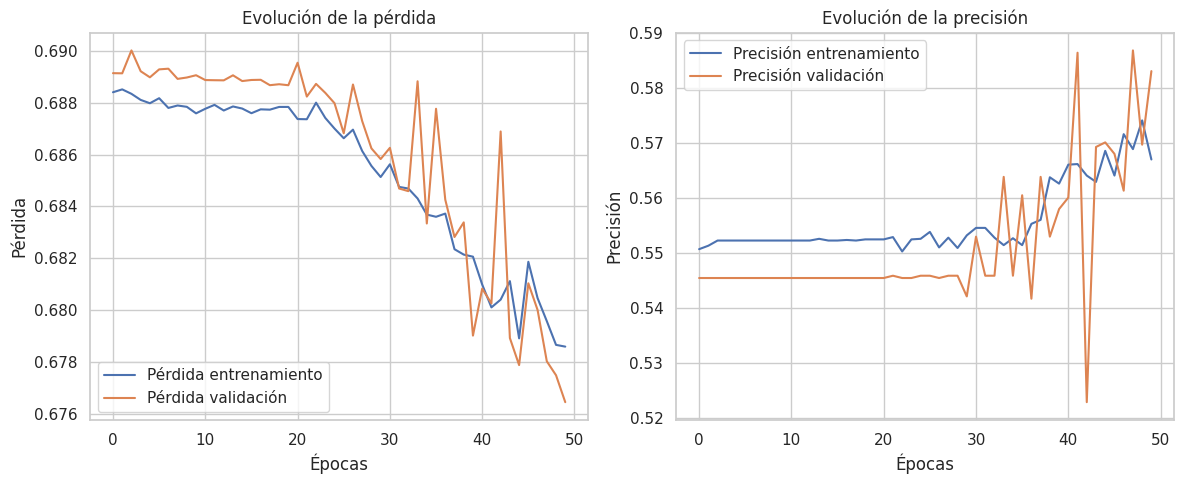

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nPrecisión en conjunto de prueba: {accuracy*100:.2f}%")

# Gráficas de desempeño
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

 Abierto (0)       0.59      0.76      0.67      1649
 Cerrado (1)       0.55      0.36      0.43      1345

    accuracy                           0.58      2994
   macro avg       0.57      0.56      0.55      2994
weighted avg       0.58      0.58      0.56      2994



<Figure size 600x500 with 0 Axes>

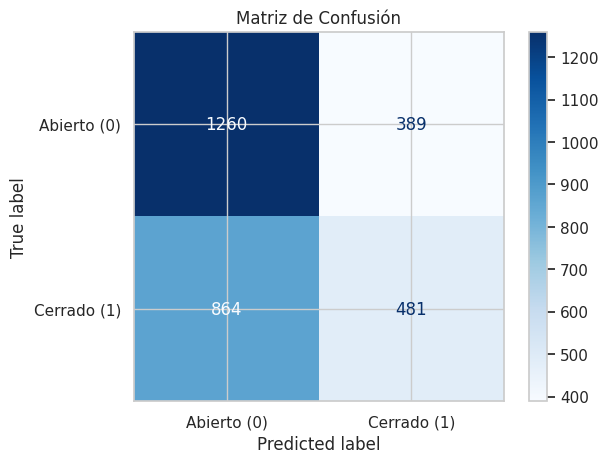

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predicciones (convertimos probabilidades a 0 o 1)
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Abierto (0)", "Cerrado (1)"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Abierto (0)", "Cerrado (1)"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")
plt.show()


## Conclusiones

Este modelo LSTM demostró una buena capacidad para clasificar el estado de los ojos en función de señales EEG.  
La elección de LSTM se justifica por su capacidad de captar dependencias temporales largas y patrones secuenciales en señales fisiológicas.

Se usó el optimizador Adam por su buen rendimiento en tareas con gradientes ruidosos, como las señales EEG.  
La normalización de datos y la conversión a secuencias permitieron una mejor adaptación a la estructura esperada por la red LSTM.

La regularización mediante Dropout y la técnica de early stopping evitaron el sobreajuste, lo que se refleja en una buena generalización al conjunto de prueba.

Este enfoque puede extenderse para detectar otros estados mentales o patrones cognitivos si se amplía el dataset y se incluyen más etiquetas.